# Standard Autoencoder

## Setup

### Imports

In [61]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [62]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

from autoencoders.autoencoder import Autoencoder
from utils.stacked_mnist import StackedMNISTData, DataMode
from utils.verification_net import VerificationNet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration

In [63]:
encoding_dim = 16
epochs = 50
batch_size = 256
force_relearn = False
mono_tolerance = 0.8
stacked_tolerance = 0.5
n_generated = 10000

## Mono MNIST

### Data

In [64]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Train

In [65]:
# Train autoencoder
autoencoder = Autoencoder(encoding_dim, x_train.shape[1:3])
autoencoder.summary()
autoencoder.train(x_train, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Could not read weights for autoencoder from file. Must retrain...
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 1, 1, 64)          200768    
___________________________________________________________

True

In [66]:
# Train verification network
net = VerificationNet(force_learn=False)
net.train(generator=gen, epochs=epochs)

img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = net.check_class_coverage(data=img, tolerance=.98)
pred, acc = net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 98.55%
Accuracy: 98.29%


### Reconstruction

**Reconstruct images and display**

In [67]:
encoded = autoencoder.encode(x_test)
reconstructed = autoencoder(x_test)

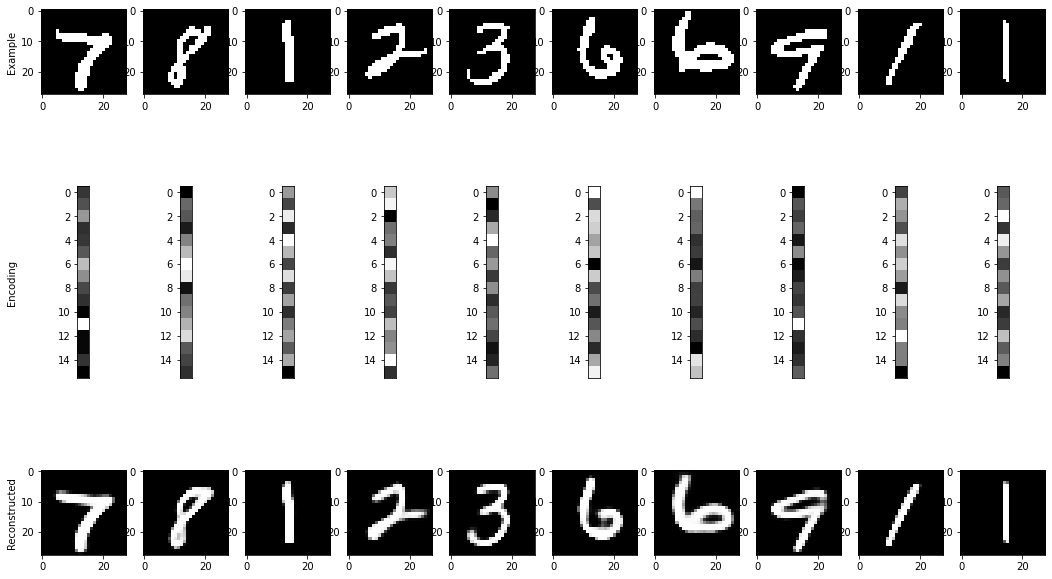

In [68]:
# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test.shape[0], n_display, replace=False)
fig, ax = plt.subplots(3, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test[n], cmap='gray')
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed[n], cmap='gray')
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Reconstructed')
fig.align_ylabels()
plt.show()

**Assess reconstructions**

In [69]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=reconstructed, tolerance=.8)
pred, acc = net.check_predictability(data=reconstructed, correct_labels=y_test, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 92.43%
Accuracy: 89.99%


### Generation

**Generate images and display**

In [70]:
z = np.random.randn(n_generated, encoding_dim, 1)
generated = autoencoder.decode(z)

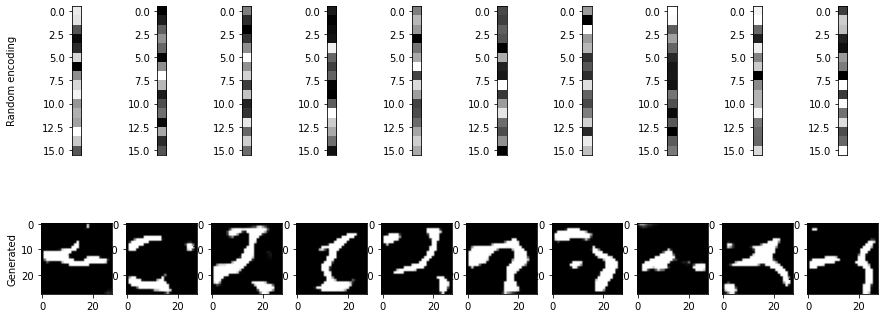

In [86]:
# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(2, n_display, figsize=(15, 6))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated[n], cmap='gray')

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Generated')
fig.align_ylabels()
plt.show()

**Assess generation**

In [72]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=generated, tolerance=.8)
pred, _ = net.check_predictability(data=generated, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 53.19%


### Anomaly Detection

**Train new model**

In [ ]:
missing_gen = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING)

# Train autoencoder
x_train_missing, y_train_missing = missing_gen.get_full_data_set(training=True)

missing_autoencoder = VariationalAutoencoder(prior_distribution, encoding_dim, x_train_missing.shape[1:3], file_name="./models/variational_missing_autoencoder/autoencoder")
missing_autoencoder.summary()
missing_autoencoder.train(x_train_missing, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)


KeyboardInterrupt: 

In [ ]:
# Calculating reconstruction losses with test set with no missing digits
loss = missing_autoencoder.reconstruction_loss(x_test)

10000/10000 [==============================] - 57s 6ms/step - loss: 113.5184


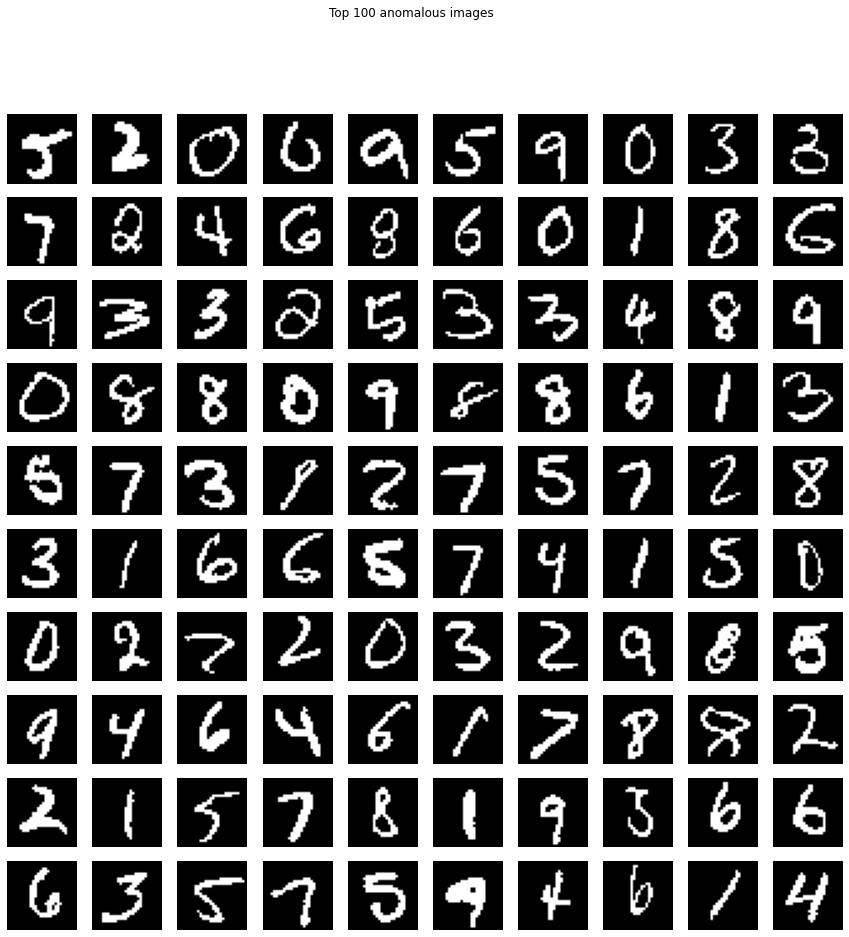

In [ ]:
# Display most anomolous images

grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test[idx[grid_size*n + m]], cmap='gray')
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()

## Color MNIST

### Data

In [87]:
color_gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)
x_train_color, y_train_color = color_gen.get_full_data_set(training=True)
x_test_color, y_test_color = color_gen.get_full_data_set(training=False)

### Train

In [88]:
color_autoencoder = Autoencoder(encoding_dim=encoding_dim, image_dim=x_train_color.shape[1:3], file_name='./models/color_autoencoder/autoencoder')
color_autoencoder.summary()
color_autoencoder.train(x_train_color, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Could not read weights for autoencoder from file. Must retrain...
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 1, 1, 64)          200768    
___________________________________________________________

### Reconstruction

**Reconstruct images and display**

In [ ]:
encoded = color_autoencoder.encode(x_test_color)
reconstructed = color_autoencoder(x_test_color)

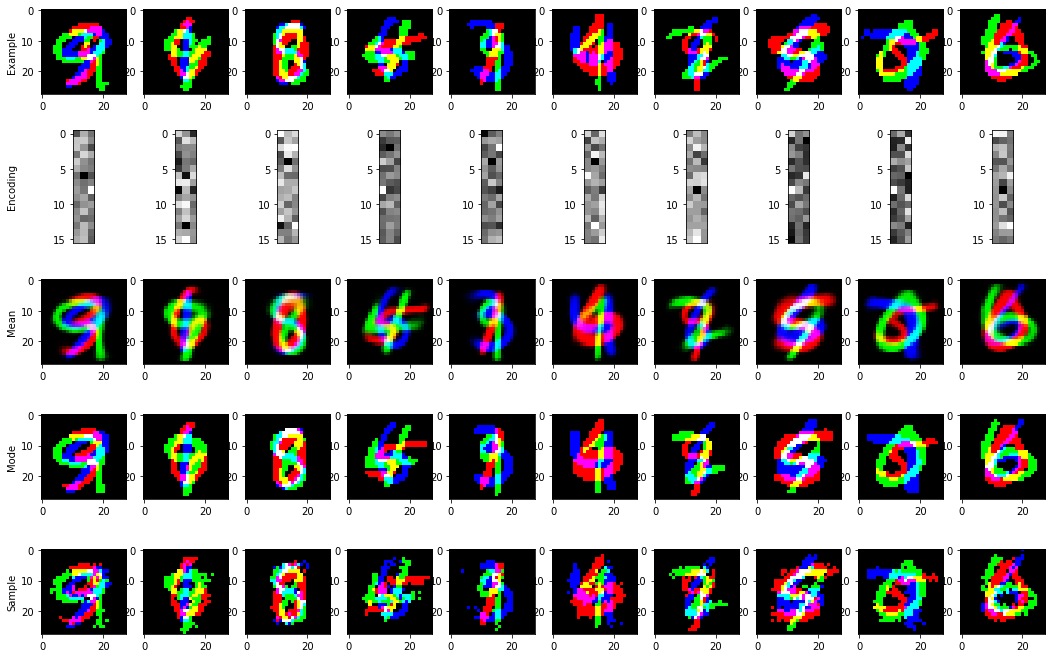

In [ ]:
# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test_color.shape[0], n_display, replace=False)
fig, ax = plt.subplots(5, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test_color[n] * 255)
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed[n])
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Reconstructed')
fig.align_ylabels()
plt.show()

**Assess reconstruction**

In [ ]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=reconstructed, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed, correct_labels=y_test_color, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

---Mean---
Coverage: 98.30%
Predictability: 78.34%
Accuracy: 54.69%
---Mode---
Coverage: 100.00%
Predictability: 98.74%
Accuracy: 86.29%
---Sample---
Coverage: 100.00%
Predictability: 95.02%
Accuracy: 81.75%


### Generation

**Generate images and display**

In [ ]:
z = np.random.randn((n_generated, encoding_dim, 3))
generated = autoencoder.decode(z)

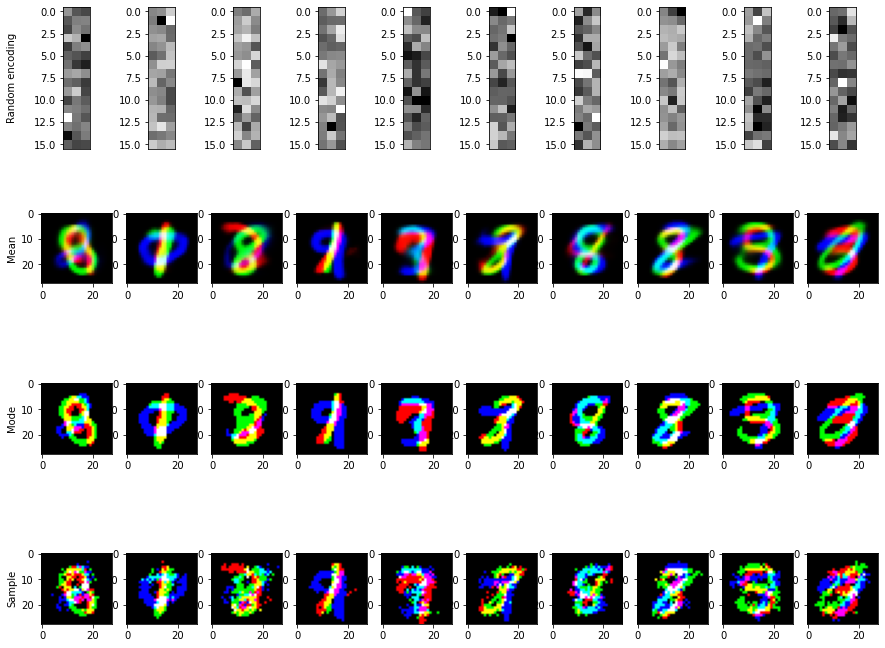

In [ ]:
# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(2, n_display, figsize=(6, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated[n])

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Generated')
fig.align_ylabels()
plt.show()

**Assess generation**

In [ ]:
# Check coverage, predictability, and accuracy
cov = net.check_class_coverage(data=generated, tolerance=.5)
pred, _ = net.check_predictability(data=generated, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

---Mean---
Coverage: 47.70%
Predictability: 49.63%
---Mode---
Coverage: 100.00%
Predictability: 89.75%
---Sample---
Coverage: 99.30%
Predictability: 67.87%
